<h1> Average Surface Air Temperature (ARIMA) </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("D:\\Datasets\\MeanSAT.csv")
df = df.drop(columns=["5-yr smooth"])
df.head()

Category  Annual Mean
0      1901        25.90
1      1902        25.89
2      1903        25.55
3      1904        24.93
4      1905        25.30

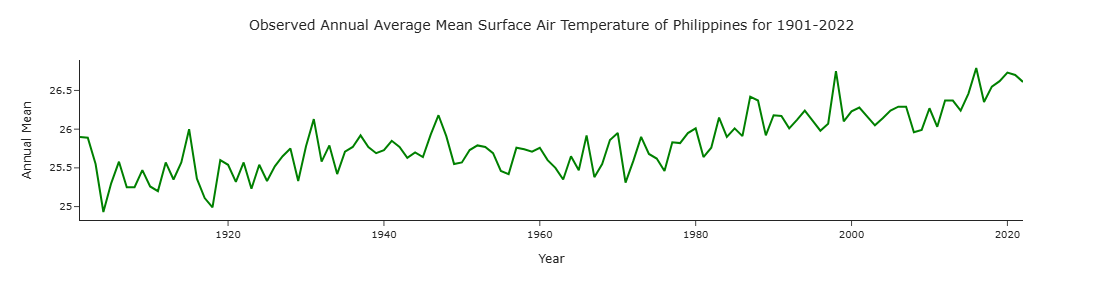

In [3]:
def MSAT (df:pd.DataFrame, y):
    fig = px.line(df, x = df["Category"], y = df["Annual Mean"], labels = {"Category":"Year"})
    fig.update_layout(template = "simple_white",
                    title_text = 'Observed Annual Average Mean Surface Air Temperature of Philippines for 1901-2022',
                    title_x = 0.5,
                    font = dict(size = 10),
                    width = 1000,
                    height = 300
                     )
    fig.update_traces(line=dict(color="green"))
    return fig.show()
MSAT (df, df["Annual Mean"])

In [4]:
#ADF Test
from statsmodels.tsa.stattools import adfuller
data_test = adfuller(df['Annual Mean'], autolag ='AIC')
print(f"TestStat: {data_test[0]}")
print(f"P-value: {data_test[1]}")
print(f"Number of Lags: {data_test[2]}")
print(f"Number of Observation: {data_test[3]}")
print("Critical Value")
for key, val in data_test[4].items():
    print(f"\t{key}:{val}")

TestStat: 0.16107380598516485
P-value: 0.969991862038501
Number of Lags: 5
Number of Observation: 116
Critical Value
	1%:-3.4880216384691867
	5%:-2.8867966864160075
	10%:-2.5802408234244947


In [5]:
from pmdarima.arima.utils import ndiffs
ndiffs(df["Annual Mean"], test='adf')

1

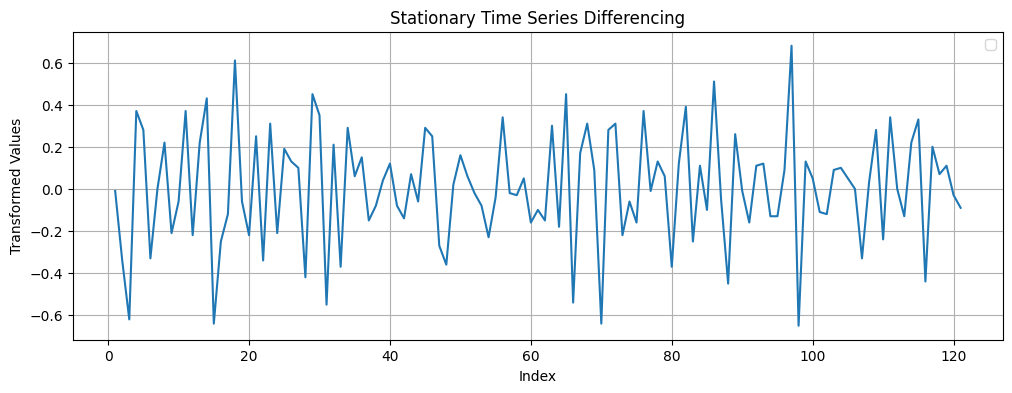

In [6]:
#Differencing
y_diff = df["Annual Mean"].diff().dropna()
# Step 5: Plot the transformed data
plt.figure(figsize=(12, 4))
plt.plot(y_diff)
plt.title('Stationary Time Series Differencing')
plt.xlabel('Index')
plt.ylabel('Transformed Values')
plt.legend()
plt.grid()
plt.show()



In [7]:
#ADF Test
from statsmodels.tsa.stattools import adfuller
data_test1 = adfuller(y_diff, autolag ='AIC')
print(f"TestStat: {data_test1[0]}")
print(f"P-value: {data_test1[1]}")
print(f"Number of Lags: {data_test1[2]}")
print(f"Number of Observation: {data_test1[3]}")
print("Critical Value")
for key, val in data_test1[4].items():
    print(f"\t{key}:{val}")

TestStat: -7.528628860947468
P-value: 3.628112389816005e-11
Number of Lags: 5
Number of Observation: 115
Critical Value
	1%:-3.4885349695076844
	5%:-2.887019521656941
	10%:-2.5803597920604915


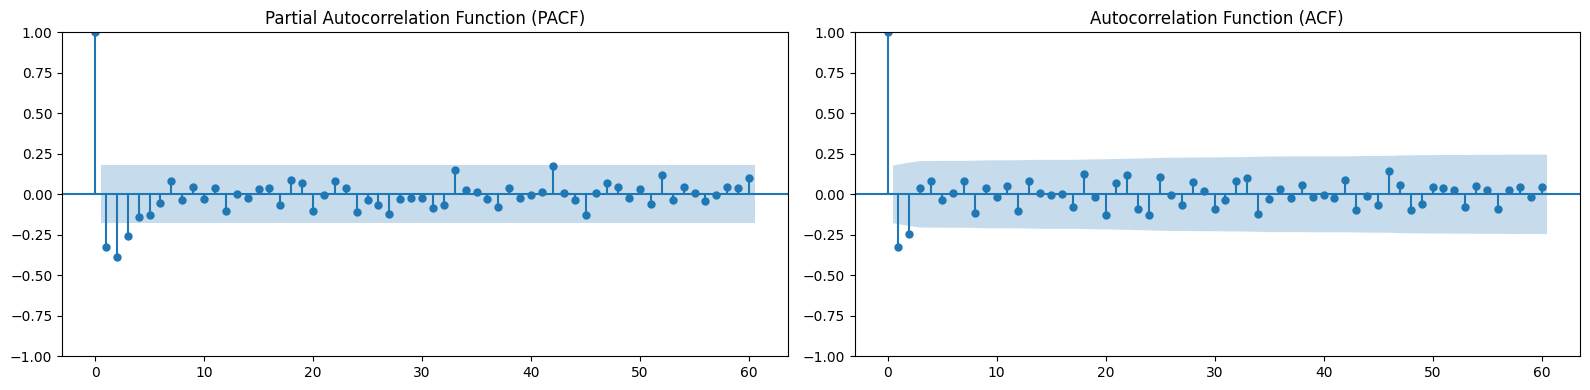

In [8]:
#Modelling: Plot PACF and ACF
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# Subplot setup for PACF and ACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

# PACF Plot
plot_pacf(y_diff, method='ywm', lags=60, ax=axes[0])
axes[0].set_title("Partial Autocorrelation Function (PACF)")

# ACF Plot
plot_acf(y_diff, lags=60, ax=axes[1])
axes[1].set_title("Autocorrelation Function (ACF)")

# Finalize the layout
plt.tight_layout()
plt.savefig("pacf(arima).png")
plt.show()

In [9]:
#split data to train and test set
train_size = int(len(y_diff)*0.8)
train = y_diff[:train_size].dropna()
test = y_diff[train_size:].dropna()

In [10]:
train.shape, test.shape

((96,), (25,))

In [11]:
#Build ARIMA Model and Inverse boxcox
from statsmodels.tsa.arima.model import ARIMA

In [12]:
# Build ARIMA Model
arima_model = ARIMA(train, 
                    order = (3, 1, 2),
                    enforce_stationarity=True,  # Allow non-stationary models
                    enforce_invertibility= False)  # Allow non-invertible model
                    
arima_model_fit = arima_model.fit()

D:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

D:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

D:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [13]:
arima_train_forecast = arima_model_fit.fittedvalues
arima_test_forecast = arima_model_fit.get_forecast(steps = len(test)).predicted_mean

D:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



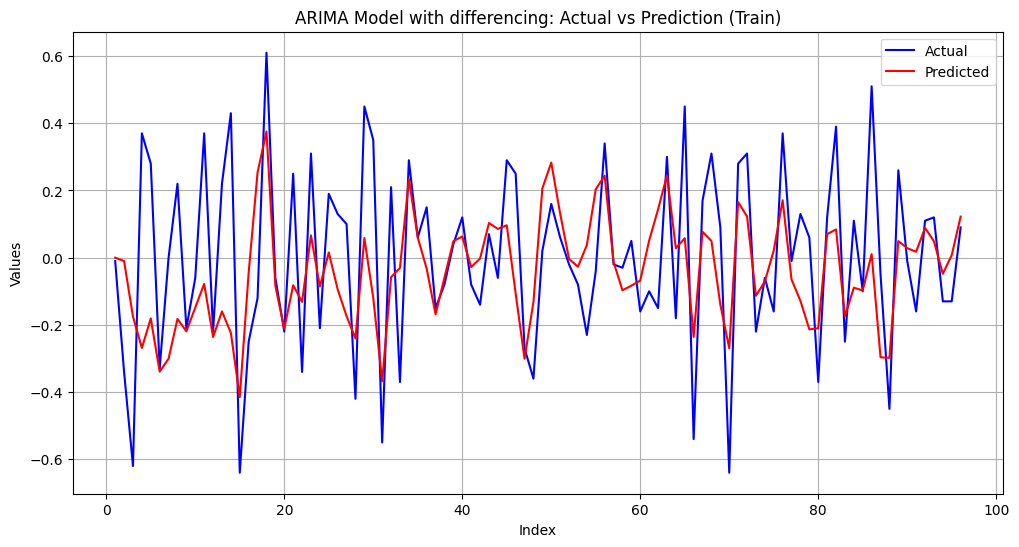

In [14]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label="Actual", color="blue")
plt.plot(arima_train_forecast, label="Predicted", color="red")
plt.title("ARIMA Model with differencing: Actual vs Prediction (Train)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(0.3)
plt.savefig("arima(train).png")
plt.show()

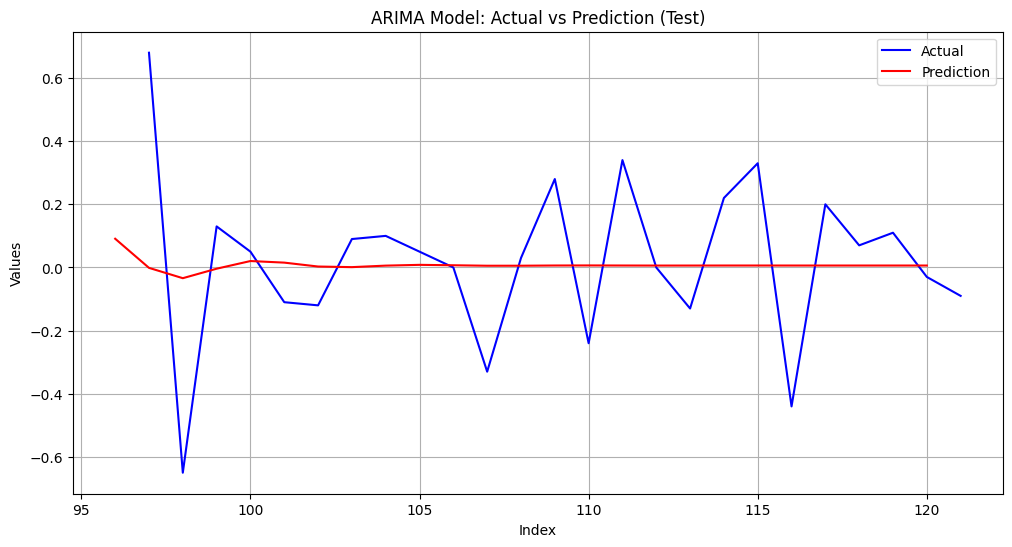

In [15]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", color="blue")
plt.plot(arima_test_forecast, label="Prediction", color="red")
plt.title("ARIMA Model: Actual vs Prediction (Test)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(0.3)
plt.savefig("arima(test)")
plt.show()

In [16]:
orig_test_val = df[train_size:]
orig_test_val["Annual Mean"]
orig_test_val.iloc[0]

Category       1997.00
Annual Mean      26.07
Name: 96, dtype: float64

In [17]:
#invert the differencing
#original data
test_reverted = test.cumsum() + df["Annual Mean"].iloc[train_size]


#reverse the scaled data
print("Reverted Test Series (length):", len(test_reverted))

Reverted Test Series (length): 25


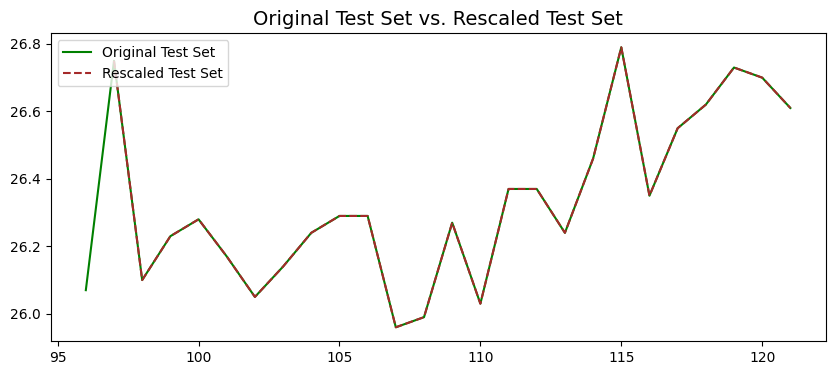

In [18]:
plt.figure(figsize=(10, 4))

# Plot with color choices
plt.plot(orig_test_val["Annual Mean"], label="Original Test Set", color='green')  
plt.plot(test_reverted, label="Rescaled Test Set", linestyle='--', color='brown')  

# Add title and legend with matching colors
plt.title("Original Test Set vs. Rescaled Test Set", fontsize=14)
plt.legend(loc="upper left")

# Show plot
plt.show()


In [19]:
# Step 1: Get the last value from the training set in the original series
last_train_value = df["Annual Mean"].iloc[train_size - 1]  # The last known value before the test set

# Step 2: Invert the differencing for the forecasted test values
forecast_reverted = arima_test_forecast.cumsum() + last_train_value


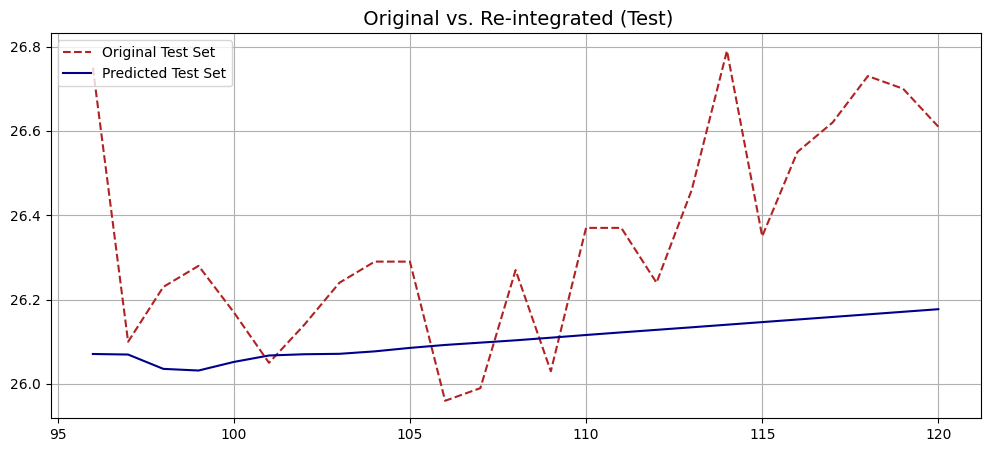

In [20]:

test_reverted.index = forecast_reverted.index


plt.figure(figsize=(12, 5))

# Plot with color choices
plt.plot(test_reverted, label="Original Test Set", linestyle='--', color='firebrick')  
plt.plot(forecast_reverted, label="Predicted Test Set", color='darkblue')  
# Add title and legend with matching colors
plt.title(" Original vs. Re-integrated (Test)", fontsize=14)
plt.legend(loc="upper left")
plt.grid(0.3)
plt.savefig("arima reintegrated.png")
plt.show()


In [21]:
result_df = pd.DataFrame({
    "Test" : test_reverted,
    "Forecast" : forecast_reverted})
                     
print(result_df.head())

      Test   Forecast
96   26.75  26.070959
97   26.10  26.069654
98   26.23  26.035667
99   26.28  26.031747
100  26.17  26.052086


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [23]:
mae = (mean_absolute_error(test_reverted, forecast_reverted)).round(2)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.26


In [24]:
mse = mean_squared_error(test_reverted, forecast_reverted).round(2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.1


In [25]:
rmse = np.sqrt(mse).round(2)
print(f" Root Mean Squared Error: {rmse}")

 Root Mean Squared Error: 0.32


In [26]:
mape = mean_absolute_percentage_error(test_reverted, forecast_reverted) * 100  # Convert to percentage
print(f"MAPE: {mape:.2f}%")

MAPE: 1.00%


In [27]:
r2 = r2_score(test_reverted, forecast_reverted).round(2)
print(f"R2 Score: {r2}")

R2 Score: -0.77


In [28]:
# Calculate MAPA
mapa = 100 - mape
print(f"MAPA: {mapa:.2f}%")

MAPA: 99.00%


In [29]:
import pandas as pd

# Create a DataFrame for clarity (optional)
data = pd.DataFrame({
    "Actual": test_reverted,
    "Predicted": forecast_reverted
})

# Calculate correlation
corr = data["Actual"].corr(data["Predicted"]).round(2)
print(f"Correlation: {corr}")


Correlation: 0.61


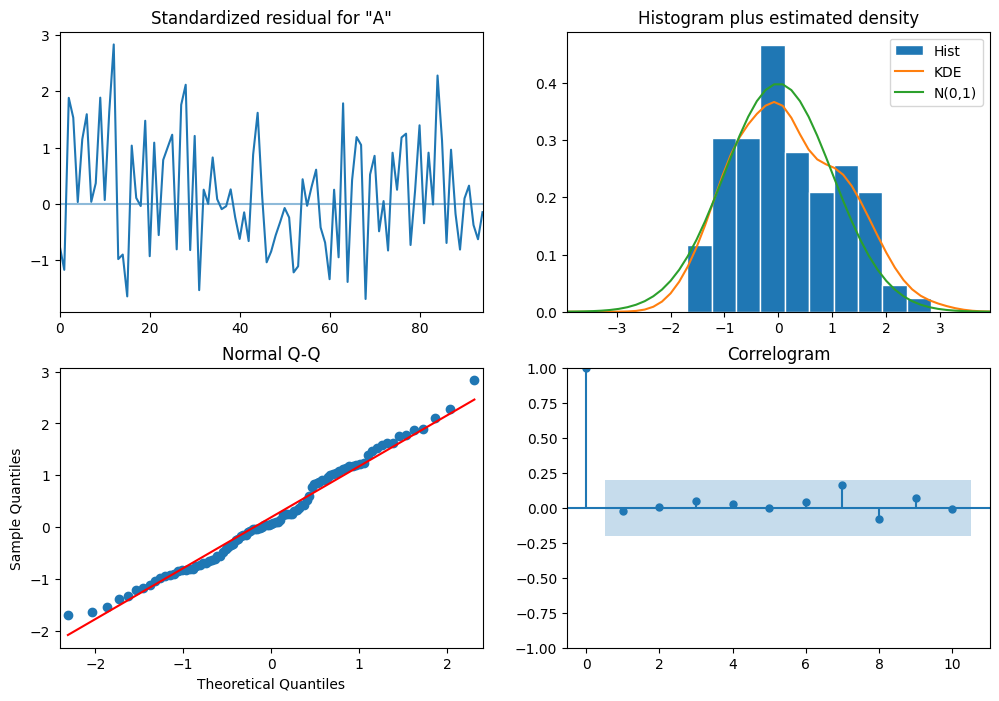

In [30]:
arima_model.fit().plot_diagnostics(figsize=(12, 8))
plt.savefig("ARIMA diag.png")
plt.show()

----------------------------------

<h3> ARIMA no Differencing </h3>

In [68]:
data = df["Annual Mean"]

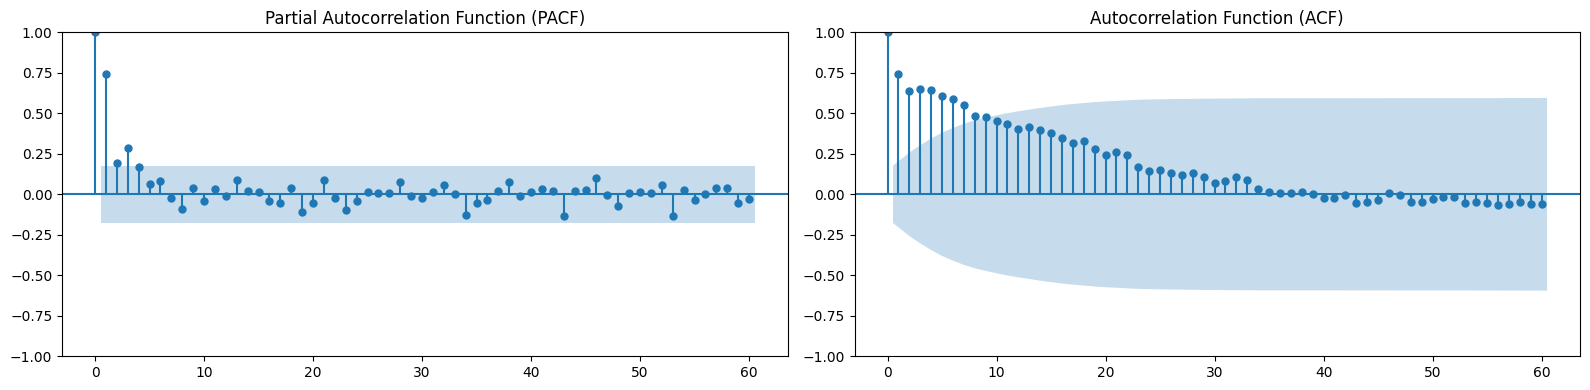

In [69]:
#Modelling: Plot PACF and ACF
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# Subplot setup for PACF and ACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

# PACF Plot
plot_pacf(data, method='ywm', lags=60, ax=axes[0])
axes[0].set_title("Partial Autocorrelation Function (PACF)")

# ACF Plot
plot_acf(data, lags=60, ax=axes[1])
axes[1].set_title("Autocorrelation Function (ACF)")

# Finalize the layout
plt.tight_layout()
#plt.savefig("pacf(arima).png")
plt.show()

In [70]:
#split data
data_train_size = int(len(data)*0.8)
data_train = data[:data_train_size]
data_test = data[data_train_size:]

In [71]:
data_train.shape, data_test.shape

((97,), (25,))

In [72]:
from statsmodels.tsa.arima.model import ARIMA

In [73]:
model_nodiff = ARIMA(data_train,
                     order = (2,0,1),
                    enforce_stationarity= False,  # Allow non-stationary models
                    enforce_invertibility= False)  
                    
nodiff_model_fit = model_nodiff.fit()

In [74]:
nodiff_train_forecast = nodiff_model_fit.fittedvalues
nodiff_test_forecast = nodiff_model_fit.get_forecast(steps = len(data_test)).predicted_mean

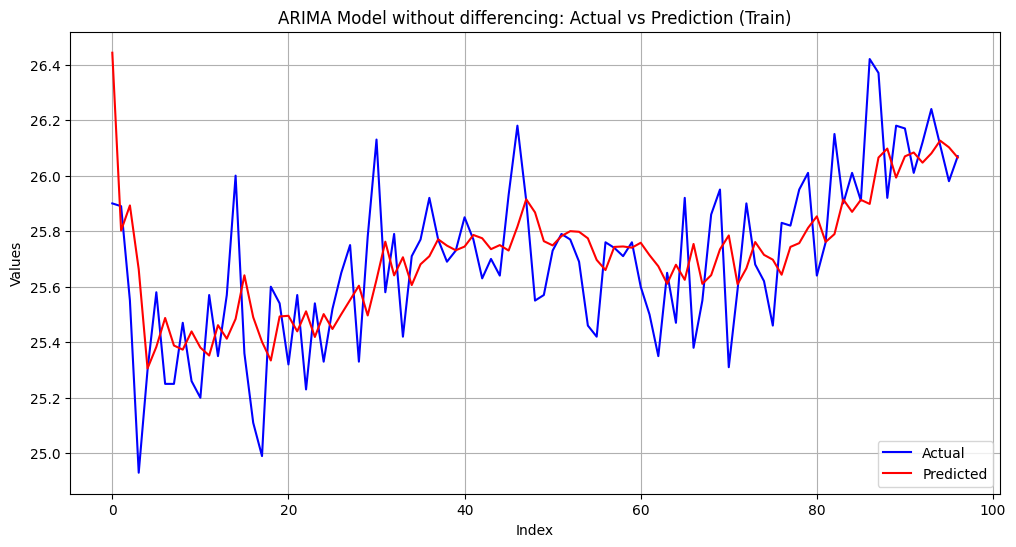

In [75]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(data_train, label="Actual", color="blue")
plt.plot(nodiff_train_forecast, label="Predicted", color="red")
plt.title("ARIMA Model without differencing: Actual vs Prediction (Train)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(0.3)
plt.savefig("arima(train no diff).png")
plt.show()

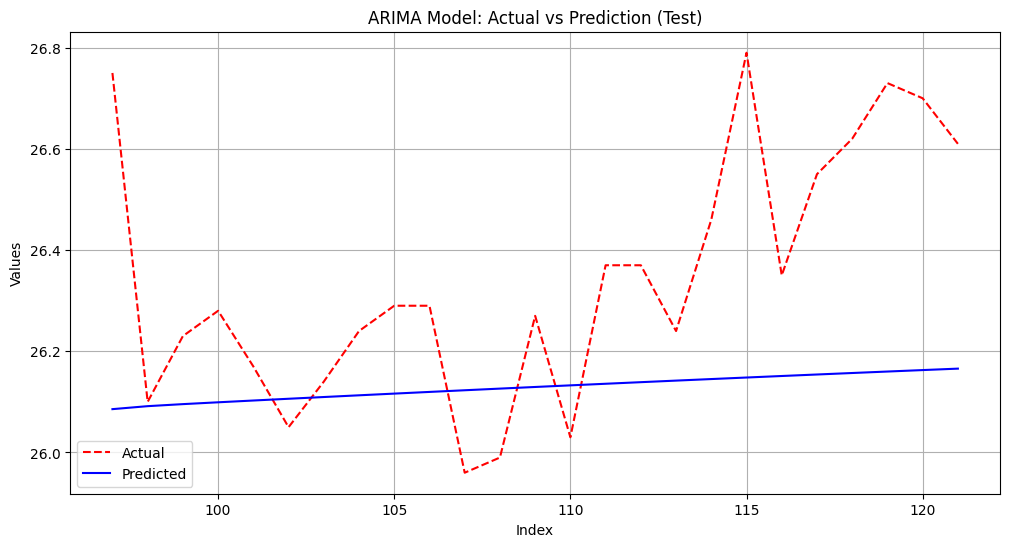

In [76]:
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(data_test, label="Actual", color="red", linestyle="--")
plt.plot(nodiff_test_forecast, label="Predicted", color="blue")
plt.title("ARIMA Model: Actual vs Prediction (Test)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(0.3)
plt.savefig("arima(test no diff).png")
plt.show()

In [77]:
result_df = pd.DataFrame({
    "Test" : data_test,
    "Forecast" : nodiff_test_forecast})
                     
print(result_df.head())

      Test   Forecast
97   26.75  26.085643
98   26.10  26.091541
99   26.23  26.095552
100  26.28  26.099173
101  26.17  26.102691


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [142]:
mae_nodiff = mean_absolute_error(data_test, nodiff_test_forecast).round(2)
print(f"Mean Absolute Error: {mae_nodiff}")

Mean Absolute Error: 0.25


In [141]:
mse_nodiff = mean_squared_error(data_test, nodiff_test_forecast).round(2)
print(f"Mean Squared Error: {mse_nodiff}")

Mean Squared Error: 0.1


In [140]:
rmse_nodiff = np.sqrt(mse_nodiff).round(2)
print(f" Root Mean Squared Error: {rmse_nodiff}")

 Root Mean Squared Error: 0.32


In [111]:
mape_nodiff = mean_absolute_percentage_error(data_test, nodiff_test_forecast) * 100  # Convert to percentage
print(f"MAPE: {mape_nodiff:.2f}%")

MAPE: 0.95%


In [112]:
# Calculate MAPA
mapa_nodiff = 100 - mape_nodiff
print(f"MAPA: {mapa_nodiff:.2f}%")

MAPA: 99.05%


In [191]:
data_nodiff = pd.DataFrame({
    "Actual": data_test,
    "Predicted": nodiff_test_forecast
})

# Calculate correlation
corr_nodiff = data_nodiff["Actual"].corr(data_nodiff["Predicted"], method = 'pearson').round(2)
print(f"Correlation: {corr_nodiff}")

Correlation: 0.52


In [139]:
r2_nodiff = r2_score(data_test, nodiff_test_forecast).round(2)
print(f"R2 Score: {r2_nodiff}")

R2 Score: -0.69


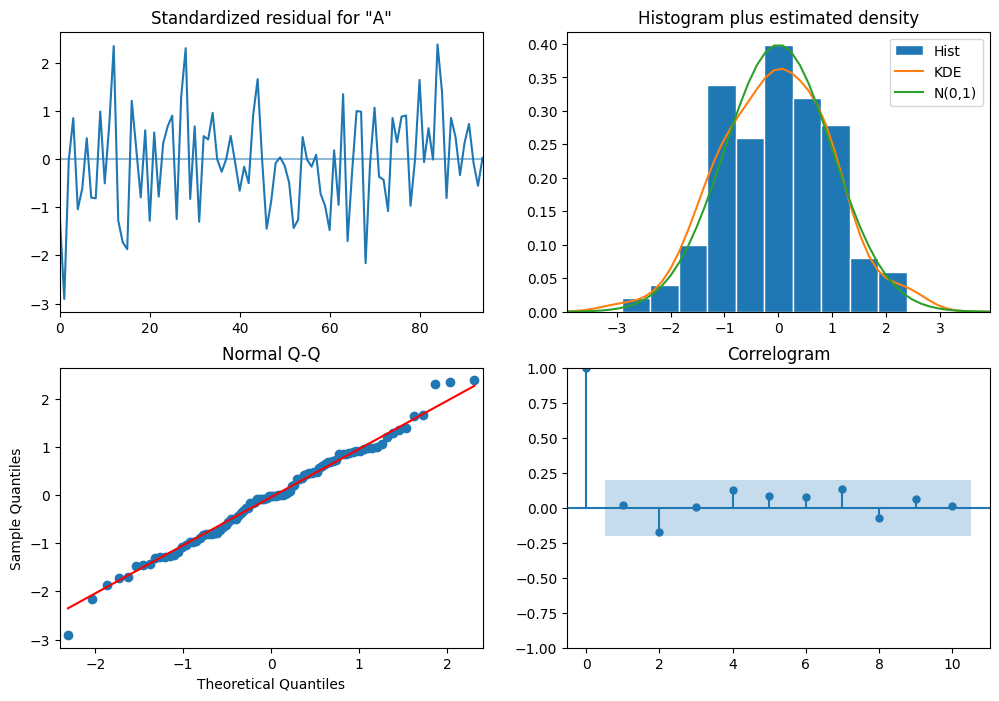

In [86]:
model_nodiff.fit().plot_diagnostics(figsize=(12, 8))
plt.show()


In [143]:
# Create the comparison table
comparison_table = pd.DataFrame({
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Mean Squared Error (MSE)",
        "Root Mean Squared Error (RMSE)",
        "Mean Absolute Percentage Error (MAPE)",
        "Mean Absolute Percentage Accuracy (MAPA)",
        "R² Score",
        "Correlation Coefficient"
    ],
    "With Differencing": [
        mae,
        mse,
        rmse,
        f"{mape:.2f}%",
        f"{mapa:.2f}%",
        r2,
        corr
    ],
    "Without Differencing": [
        mae_nodiff,
        mse_nodiff,
        rmse_nodiff,
        f"{mape_nodiff:.2f}%",
        f"{mapa_nodiff:.2f}%",
        r2_nodiff,
        corr_nodiff
    ]
})

# Display the table
print(comparison_table)

                                     Metric With Differencing  \
0                 Mean Absolute Error (MAE)              0.26   
1                  Mean Squared Error (MSE)               0.1   
2            Root Mean Squared Error (RMSE)              0.32   
3     Mean Absolute Percentage Error (MAPE)             1.00%   
4  Mean Absolute Percentage Accuracy (MAPA)            99.00%   
5                                  R² Score             -0.77   
6                   Correlation Coefficient              0.61   

  Without Differencing  
0                 0.25  
1                  0.1  
2                 0.32  
3                0.95%  
4               99.05%  
5                -0.69  
6                 0.52  


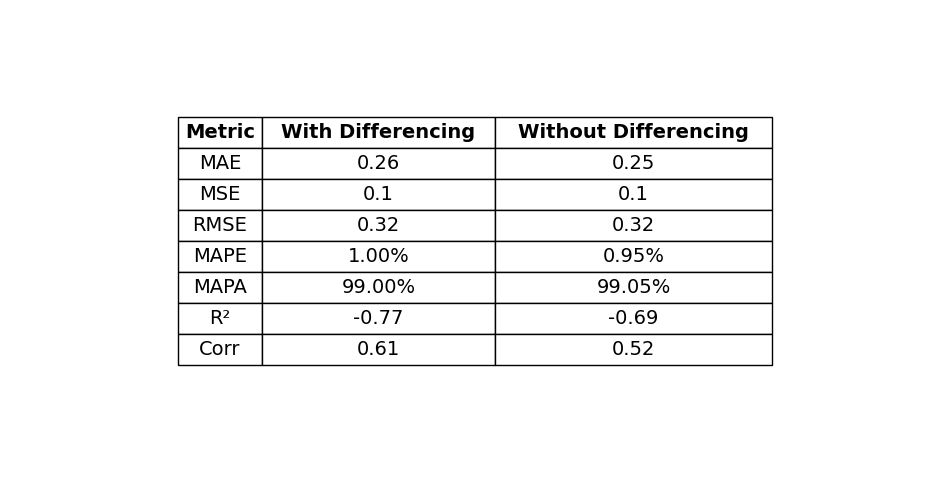

In [185]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the comparison table
comparison_table = pd.DataFrame({
    "Metric": [
        "MAE",
        "MSE",
        "RMSE",
        "MAPE",
        "MAPA",
        "R²",
        "Corr"
    ],
    "With Differencing": [
        mae,
        mse,
        rmse,
        f"{mape:.2f}%",
        f"{mapa:.2f}%",
        r2,
        corr
    ],
    "Without Differencing": [
        mae_nodiff,
        mse_nodiff,
        rmse_nodiff,
        f"{mape_nodiff:.2f}%",
        f"{mapa_nodiff:.2f}%",
        r2_nodiff,
        corr_nodiff
    ]
})

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size for better clarity
ax.axis('tight')
ax.axis('off')

# Create a table from the DataFrame
table = ax.table(
    cellText=comparison_table.values,
    colLabels=comparison_table.columns,
    cellLoc='center',
    loc='center'
)

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(14)  # Increase font size
table.auto_set_column_width(col=list(range(len(comparison_table.columns))))  # Adjust column width

# Make column headers bold
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(fontweight='bold')

# Adjust cell height and layout
for key, cell in table.get_celld().items():
    cell.set_height(0.067)  # Increase cell height

# Save the figure with enhanced quality
plt.savefig("ARIMA_eval.png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Show the table
plt.show()
